<a href="https://colab.research.google.com/github/jganzabal/Bioinformatics/blob/master/ITBA_AUDIO_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agregado del dataset a Google Drive propio

Hacer click en el siguiente link:

https://drive.google.com/file/d/1I3yWgx9HC-TEmfRr6hgB_dZPcy7qhrZK/view?usp=sharing

Agregarlo a tu drive con el icono de '+'


# Login a Drive, unzip y bajada de librería

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! unzip "/content/drive/My Drive/audios_itba.zip" > /dev/null

In [5]:
! wget https://raw.githubusercontent.com/deeplearning-itba/FAT2019-Reducida/master/freesound_helper.py

--2019-10-03 15:12:30--  https://raw.githubusercontent.com/deeplearning-itba/FAT2019-Reducida/master/freesound_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22500 (22K) [text/plain]
Saving to: ‘freesound_helper.py’

freesound_helper.py 100%[===================>]  21.97K  --.-KB/s    in 0.003s  

2019-10-03 15:12:30 (6.18 MB/s) - ‘freesound_helper.py’ saved [22500/22500]



# Carga y análisis de dataset 
Si ya tiene cargado el dataset puede arrancar desde aca despues de restart runtime

In [0]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
import librosa

In [0]:
DATA = Path('ITBA_dataset/')
AUDIOS_FOLDER = DATA/'audios'

In [0]:
annotations = pd.read_csv(DATA/'train.csv')[['fname', 'labels']]

In [4]:
annotations.head()

,fname,labels
0,001ec0ad.wav,Finger_snapping
1,0026f116.wav,Finger_snapping
2,0217540b.wav,Zipper_(clothing)
3,030d5b55.wav,Finger_snapping
4,037b9243.wav,Marimba_and_xylophone


In [5]:
from collections import Counter
Counter(annotations['labels'])

Counter({'Computer_keyboard': 75,
         'Finger_snapping': 75,
         'Gong': 75,
         'Keys_jangling': 75,
         'Marimba_and_xylophone': 75,
         'Printer': 75,
         'Scissors': 75,
         'Skateboard': 75,
         'Zipper_(clothing)': 75})

In [6]:
# Nos quedamos con las categorías
categories = np.array(list(set(annotations['labels'])))
print(categories)

['Scissors' 'Printer' 'Marimba_and_xylophone' 'Skateboard' 'Gong'
 'Finger_snapping' 'Computer_keyboard' 'Keys_jangling' 'Zipper_(clothing)']


In [0]:
# ONE HOT ENCONDIG
y_train = np.vstack(annotations['labels'].apply(lambda x: x.split(',')).apply(lambda x: np.isin(categories, x))).astype(int)
# Formateamos lectura de files
X_train = annotations['fname'].apply(lambda x: AUDIOS_FOLDER/x).values

In [21]:
# Escuchamos audios
i = 11 # Indice del audio a escuchar
X_i, sr = librosa.load(X_train[i], sr=None)
print(np.array(categories)[np.array(y_train[i]).astype(bool)])
ipd.Audio(X_i.reshape(-1), rate=sr)

['Marimba_and_xylophone']


# Importamos Generator y graficamos salida (MEL Spectrogram)

In [0]:
from freesound_helper import DataGeneratorMel

In [0]:
# Split train/val
np.random.seed(42)
indexes = np.arange(len(X_train))
np.random.shuffle(indexes)
tr_cut = int(np.round(len(indexes)*0.8))

In [0]:
# Hyperparámetros
audio_duration = 2
sample_rate = int(44100)
batch_size = 32
n_fft = 2048
hop_length = 4*256

In [0]:
dataGen_train_mel = DataGeneratorMel(X_train[indexes[:tr_cut]], y_train[indexes[:tr_cut]], None, 
                              batch_size=batch_size, audio_duration=audio_duration, sample_rate=sample_rate, 
                                     hop_length=hop_length, n_fft=n_fft)
dataGen_val_mel = DataGeneratorMel(X_train[indexes[tr_cut:]], y_train[indexes[tr_cut:]], None, 
                            batch_size=batch_size, audio_duration=audio_duration, sample_rate=sample_rate, 
                                   hop_length=hop_length, n_fft=n_fft)

In [29]:
def get_batch(dataGen):
    for X, y in dataGen:
        break
    return X, y
%time X_mel, y_mel = get_batch(dataGen_train_mel)

CPU times: user 644 ms, sys: 799 ms, total: 1.44 s
Wall time: 4.19 s


In [30]:
X_mel.shape, y_mel.shape

((32, 128, 87, 1), (32, 9))

['Zipper_(clothing)']


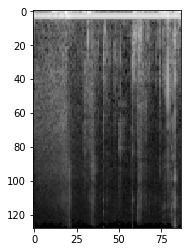

(128, 87, 1)
1.4628571428571429


In [31]:
# Visualización de salida de generator
i = 3
print(categories[np.where(y_mel[i]==1)[0]])
plt.imshow(X_mel[i].reshape(X_mel[i].shape[:2]), cmap='gray')
plt.show()
print(X_mel[i].shape)
print(63 * hop_length / sample_rate)

# Armar CNN